In [27]:
"""Note: this nb is self-contained, just requires the one saved pkl model in the results folder.
The point is to show evidence that BERT-like models meaningfully capture embeddings via summation.
One nice plot would be showing that emb('not') + emb('good') is close to emb('not good')
Another nice plot would be showing that, when trained on embeddings, coef('not') + coef('good') is not equal to coef('not good')
"""

%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import analyze_helper
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import string
from typing import List
import data
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compute embeddings and coefs

To skip to making useful plots, skip to the next main header

Compute embeddings for sst2 using bert finetuned model.

In [2]:
class A:
    checkpoint = 'textattack/bert-base-uncased-SST-2'
    dataset = 'sst2'
    padding = True

# set up model
def get_embs(texts: List[str]):
    tokenizer = AutoTokenizer.from_pretrained(args.checkpoint) # for actually passing things to the model
    model = BertModel.from_pretrained(args.checkpoint)

    tokens = tokenizer(texts, padding=args.padding, truncation=True, return_tensors="pt")
    output = model(**tokens) # this takes a while....
    embs = output['pooler_output'].cpu().detach().numpy()
    return embs


args = A()

# data
dataset, args = data.process_data_and_args(args)

# countvectorizer
tok_simp = English().tokenizer
tokenizer_func = lambda x: [str(x) for x in tok_simp(x)] 
v = CountVectorizer(tokenizer=tokenizer_func)
v.fit(dataset['train']['sentence'])
words = sorted(list(v.vocabulary_.keys()))

"""Note that vocab is already based on words being sorted
remap_idxs = {
    i: v.vocabulary_[k] for i, k in enumerate(words)
}
for i in range(len(remap_idxs)):
    assert remap_idxs[i] == i
"""

try:
    embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))
except:
    embs = get_embs(words)
    os.makedirs(config.misc_dir)
    pkl.dump(embs, open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'wb'))
    pkl.dump(words, open(oj(config.misc_dir, 'word_list_sst_train.pkl'), 'wb'))

Using custom data configuration default
Reusing dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Compute unigram-embedding linear coefficients.

In [9]:
try:
    df = pd.read_csv(oj(config.misc_dir, 'df_unigram_sst.csv'), index_col=0)
except:
    # countvec coefs
    matrix = v.transform(dataset['train']['sentence'])
    tot_counts = pd.DataFrame(matrix.sum(axis=0), columns=v.get_feature_names())
    m = LogisticRegressionCV()
    m.fit(matrix, dataset['train']['label'])
    coef = m.coef_.flatten() # note -- coef has not been mapped to same idxs as words

    # make df
    df = pd.DataFrame.from_dict({
        'coef': coef,
        'tot_counts': tot_counts.values.squeeze(),
        'unigram': words,
    })
    # df.to_csv(oj(config.misc_dir, 'df_unigram_sst.csv'))

Plot the correlations of the embeddings of the unigrams with the highest absolute value coefficients.

/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1200 with 0 Axes>

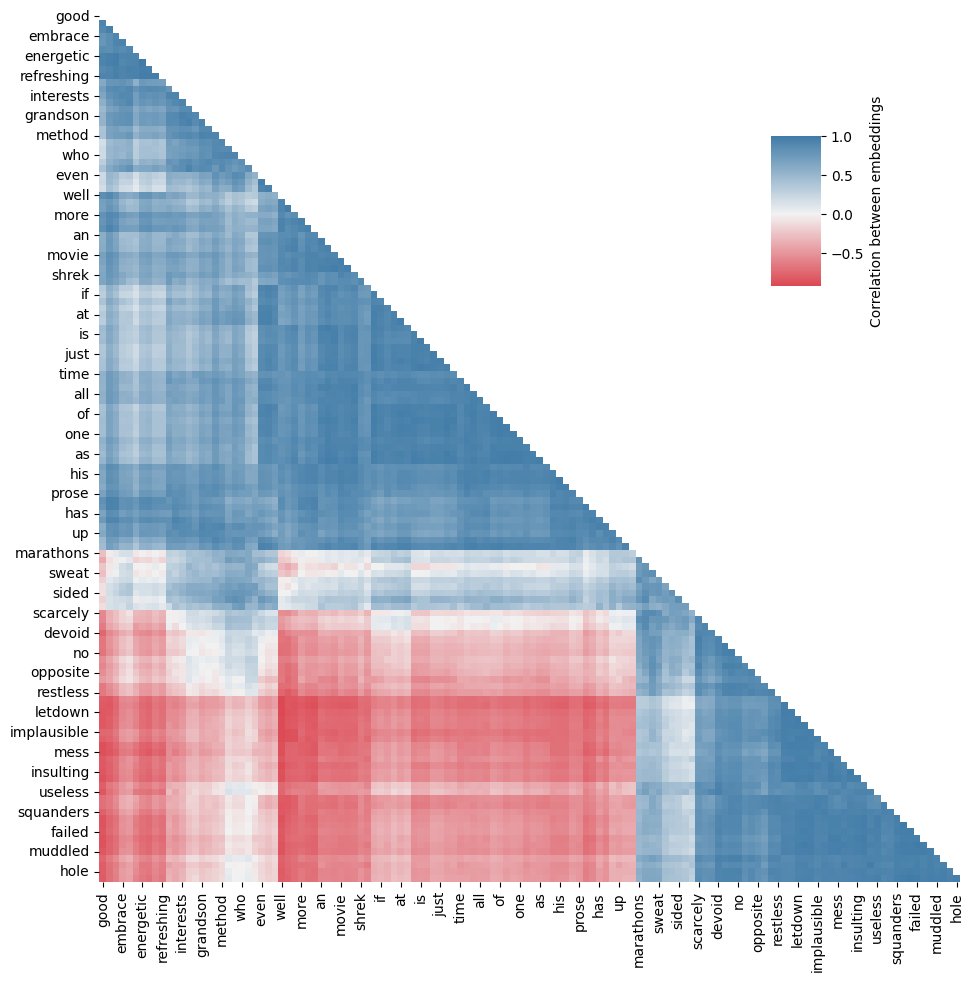

In [30]:
analyze_helper.corrplot_max_abs_unigrams(df, embs)

# bigram analysis

Here we will compare coefs of common bigrams to the sum of the coefs of their unigrams

**get bigram coefs and add them to a df with the corresponding unigram coefs**

In [21]:
try:
    df2 = pd.read_csv(oj(config.misc_dir, 'df_bigram_sst.csv'), index_col=0)
except:
    # fit countvec model
    v2 = CountVectorizer(tokenizer=tokenizer_func, ngram_range=(2, 2))
    v2.fit(dataset['train']['sentence'])

    # countvec coefs
    matrix2 = v2.transform(dataset['train']['sentence'])
    tot_counts2 = pd.DataFrame(matrix2.sum(axis=0), columns=v2.get_feature_names())
    m2 = LogisticRegressionCV()
    m2.fit(matrix2, dataset['train']['label'])
    coef2 = m2.coef_.flatten() # note -- coef has not been mapped to same idxs as words

    df2 = pd.DataFrame.from_dict({
        'coef': coef2,
        'tot_counts': tot_counts2.values.squeeze(),
    #     'unigram': words,
        'bigram': sorted(list(v2.vocabulary_.keys()))
    })

    def find_unigram_scores(bigram):
        unigram1, unigram2 = bigram.split(' ')
        unigram1_score = df.loc[df['unigram'] == unigram1, 'coef'].iloc[0]
        unigram2_score = df.loc[df['unigram'] == unigram2, 'coef'].iloc[0]
        return unigram1, unigram2, unigram1_score, unigram2_score

    out = list(zip(*df2['bigram'].map(find_unigram_scores)))
    for (i, c) in enumerate(['unigram1', 'unigram2', 'coef1', 'coef2']):
        df2[c] = out[i]

    df2.to_csv(oj(config.misc_dir, 'df_bigram_sst.csv'))

/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to 

**get bigram embeddings**

In [31]:
df2['interaction_score'] = abs(df2['coef'] - (df2['coef1'] + df2['coef2']))
df2 = df2[['bigram', 'interaction_score', 'tot_counts', # reordering
           'coef', 'coef1', 'coef2', 'unigram1', 'unigram2', ]]


**here we can just see which bigrams interact the most** 
(Nothing to do with embeddings yet)

In [32]:
d = df2.sort_values('interaction_score', ascending=False).round(2)
d = d[d.tot_counts > 2]
d = d.head(200)

bigrams = d['bigram'].values.tolist()
embs2 = get_embs(bigrams)

pkl.dump(embs2, open(oj(config.misc_dir, 'embs2_sst_top_interactions.pkl'), 'wb'))
pkl.dump(bigrams, open(oj(config.misc_dir, 'word_list_sst_top_interactions.pkl'), 'wb'))
pkl.dump(d, open(oj(config.misc_dir, 'top_interacting_words_df2.pkl'), 'wb'))

# Let's compare bert coefs to the BOW coefs

In [36]:
df = pd.read_csv(oj(config.misc_dir, 'df_unigram_sst.csv'), index_col=0)
df2 = pd.read_csv(oj(config.misc_dir, 'df_bigram_sst.csv'), index_col=0)
d = pkl.load(open(oj(config.misc_dir, 'top_interacting_words_df2.pkl'), 'rb'))

embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))
embs2 = pkl.load(open(oj(config.misc_dir, 'embs2_sst_top_interactions.pkl'), 'rb'))

In [52]:
def add_bert_coefs(d, df):

    """
    r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'],
                                dset_filters=['sst2'],
                                drop_model=False)
    ex_model = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]
    """

    # pickled with python 3.8
    ex_model = pkl.load(open('results/sst_bert_finetuned_ngrams=2.pkl', 'rb'))
    logistic = ex_model.model
    coef_bert = logistic.coef_.squeeze()

    d['bert_coef_bigram'] = embs2 @ coef_bert
    df['bert_coef_unigram'] = embs @ coef_bert # used for looking-up

    def find_unigram_scores(unigram):
        return df.loc[df['unigram'] == unigram, 'bert_coef_unigram'].iloc[0]
    d['bert_coef_unigram1'] = d['unigram1'].apply(find_unigram_scores)
    d['bert_coef_unigram2'] = d['unigram2'].apply(find_unigram_scores)
    return d
d = add_bert_coefs(d, df)

/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [53]:
d.head()

,bigram,interaction_score,tot_counts,coef,coef1,coef2,unigram1,unigram2,bert_coef_bigram,bert_coef_unigram1,bert_coef_unigram2
44950,not bad,13.26,7,6.46,-3.19,-3.61,not,bad,0.350199,-0.337425,-0.796018
57713,spielberg calls,13.04,7,0.09,3.81,9.32,spielberg,calls,-0.214195,0.375404,-0.783104
43880,n't lost,13.02,14,4.86,-3.65,-4.51,n't,lost,0.511850,-0.394974,-0.889112
44408,never lacks,12.68,4,4.27,-1.10,-7.31,never,lacks,0.793433,-0.312836,-1.294468
14407,banal bore,12.44,4,-2.45,-4.88,-10.02,banal,bore,-1.196036,-0.872826,-1.263071


not bad
not


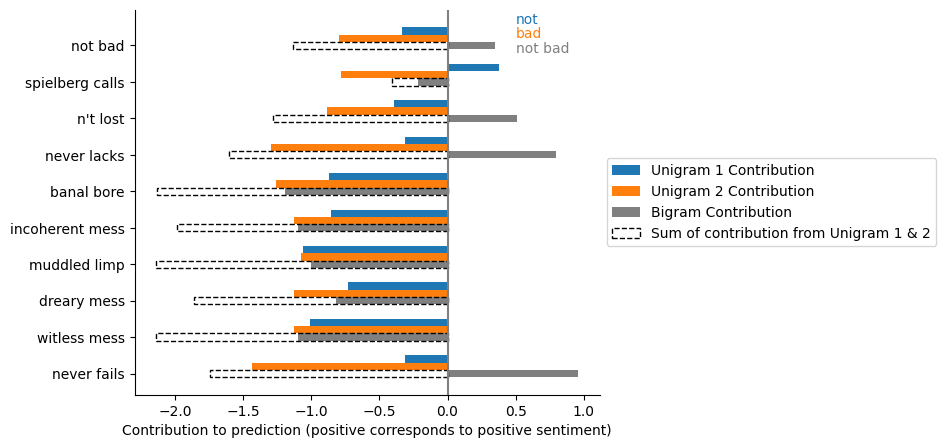

In [97]:
plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
idxs = np.arange(10)
dp = d.iloc[idxs]

idxs = idxs[::-1]
# plt.barh(idxs, dp['coef'], height=0.3)
# plt.barh(idxs + 0.3, dp['coef1'], height=0.3)
# plt.barh(idxs + 0.6, dp['coef2'], height=0.3)
height = 0.2

cmid = '#996680'
plt.barh(idxs + 2 * height, dp['bert_coef_unigram1'], height=height, label='Unigram 1 Contribution') #, color=dvu.cb)
plt.barh(idxs + height, dp['bert_coef_unigram2'], height=height, label='Unigram 2 Contribution') #, color=dvu.cr)
plt.barh(idxs, dp['bert_coef_bigram'], height=height, label='Bigram Contribution', color='gray') #, color=cmid)
plt.barh(idxs, dp['bert_coef_unigram1'] + dp['bert_coef_unigram2'], linestyle='--',
            height=height, label='Sum of contribution from Unigram 1 & 2', fill=False) #, color=dvu.cr)

prop_cycle = plt.rcParams['axes.prop_cycle']
cs = prop_cycle.by_key()['color']
ex_one = dp.iloc[0]
print(ex_one.bigram)
print(ex_one.unigram1)
plt.text(x=0.5, y=idxs.max() + height * 2 + height, s=ex_one.unigram1, color=cs[0])
plt.text(x=0.5, y=idxs.max() + height, s=ex_one.unigram2, color=cs[1])
plt.text(x=0.5, y=idxs.max() - height , s=ex_one.bigram, color='gray')

plt.axvline(0, color='gray')
plt.yticks(idxs, dp['bigram'])
plt.xlabel('Contribution to prediction (positive corresponds to positive sentiment)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
plt.savefig('results/bert_coefs_learn_interactions.pdf', bbox_inches = "tight")
plt.show()

# less clear plots

**bert coefs are similar to bigram coefs**

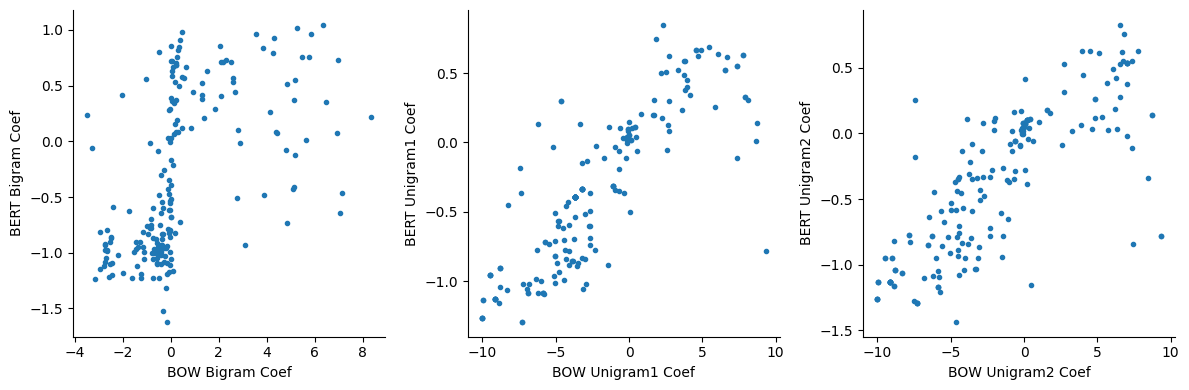

In [50]:
R, C = 1, 3
# fig, axes = plt.subplots(R, C)
# .lmplot(x='coef', y='bert_coef_bigram', data=d, ax=axes[0])
plt.figure(figsize=(12, 4))
plt.subplot(R, C, 1)
plt.plot(d['coef'], d['bert_coef_bigram'], '.')
plt.xlabel('BOW Bigram Coef')
plt.ylabel('BERT Bigram Coef')

plt.subplot(R, C, 2)
plt.plot(d['coef1'], d['bert_coef_unigram1'], '.')
plt.xlabel('BOW Unigram1 Coef')
plt.ylabel('BERT Unigram1 Coef')

plt.subplot(R, C, 3)
plt.plot(d['coef2'], d['bert_coef_unigram2'], '.')
plt.xlabel('BOW Unigram2 Coef')
plt.ylabel('BERT Unigram2 Coef')
plt.tight_layout()
plt.savefig('results/bert_bow_coef_compare.pdf')
plt.show()

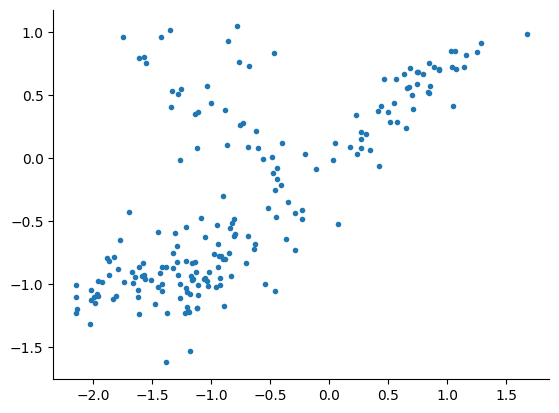

In [51]:
plt.plot(d['bert_coef_unigram1'] + d['bert_coef_unigram2'], d['bert_coef_bigram'], '.')